In [1]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn import metrics
import numpy
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

In [3]:
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

In [4]:
df = pd.read_csv('energydata_complete.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['Only_Date'] = df['date'].dt.date

In [6]:
df.groupby(['Only_Date']).mean()['Appliances'].head()

Only_Date
2016-01-11    136.666667
2016-01-12     85.694444
2016-01-13     97.013889
2016-01-14    151.388889
2016-01-15    125.347222
Name: Appliances, dtype: float64

In [7]:
series = df.groupby(['Only_Date']).mean()['Appliances']

In [8]:
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

In [9]:
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params

In [10]:
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
error = metrics.mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
r2 = metrics.r2_score(test,predictions)
print('Test R2 :%.3f'%r2)

Test MSE: 811.605
Test R2 :0.339


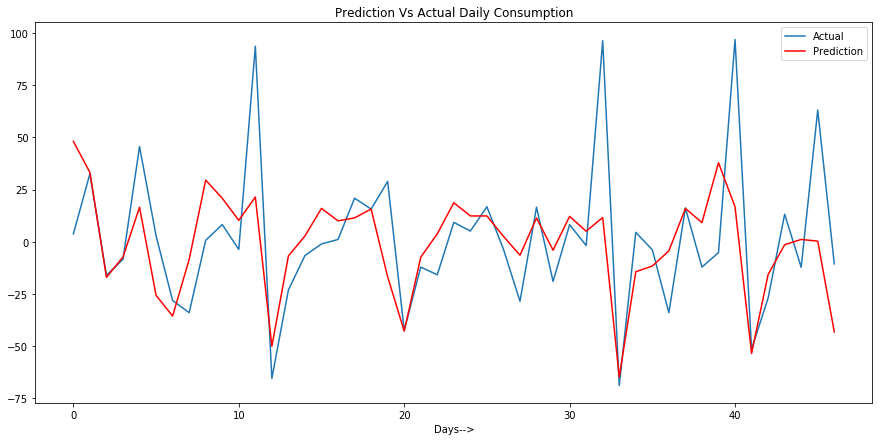

In [13]:
# plot
pyplot.figure(figsize=(15,7))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('Prediction Vs Actual Daily Consumption')
pyplot.legend(['Actual','Prediction'])
pyplot.xlabel('Days-->')
pyplot.show()